# Projection onto mean line

In [ ]:
import probe_gen.probes as probes

layer = 20

activations_tensor_on, attention_mask_on, _ = probes.load_hf_activations_and_labels(
    "AdrSkapars/anthropic-refusal-activations", 
    f"on_policy_balanced_5k_layer_{layer}", 
    "../data/refusal/on_policy_balanced_5k.jsonl", 
    verbose=True
)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_off, attention_mask_off, _ = probes.load_hf_activations_and_labels(
    "AdrSkapars/anthropic-refusal-activations", 
    f"off_policy_balanced_5k_layer_{layer}", 
    "../data/refusal/off_policy_balanced_5k.jsonl", 
    verbose=True
)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

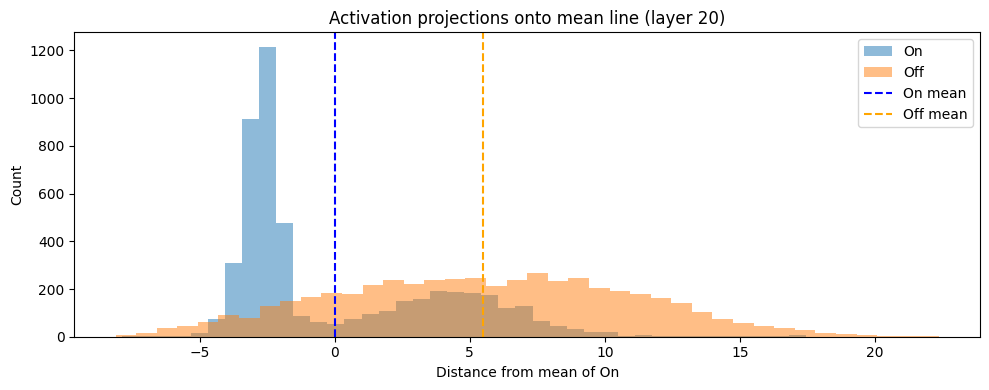

In [2]:
from probe_gen.analysis import plot_activations_mean_line_projections

plot_activations_mean_line_projections(activations_tensor_on, activations_tensor_off, ['On', 'Off'], layer)


# PCA

In [1]:
import probe_gen.probes as probes

layer = 20

activations_tensor_on, attention_mask_on, _ = probes.load_hf_activations_and_labels(
    "AdrSkapars/anthropic-refusal-activations", 
    f"on_policy_balanced_5k_layer_{layer}", 
    "../data/refusal/on_policy_balanced_5k.jsonl", 
    verbose=True
)
activations_tensor_on = probes.MeanAggregation()(activations_tensor_on, attention_mask_on)

activations_tensor_off, attention_mask_off, _ = probes.load_hf_activations_and_labels(
    "AdrSkapars/anthropic-refusal-activations", 
    f"off_policy_balanced_5k_layer_{layer}", 
    "../data/refusal/off_policy_balanced_5k.jsonl", 
    verbose=True
)
activations_tensor_off = probes.MeanAggregation()(activations_tensor_off, attention_mask_off)

loaded labels
loaded activations with shape torch.Size([5000, 277, 3072])
calculated attention mask with shape torch.Size([5000, 277])
loaded labels
loaded activations with shape torch.Size([5000, 399, 3072])
calculated attention mask with shape torch.Size([5000, 399])


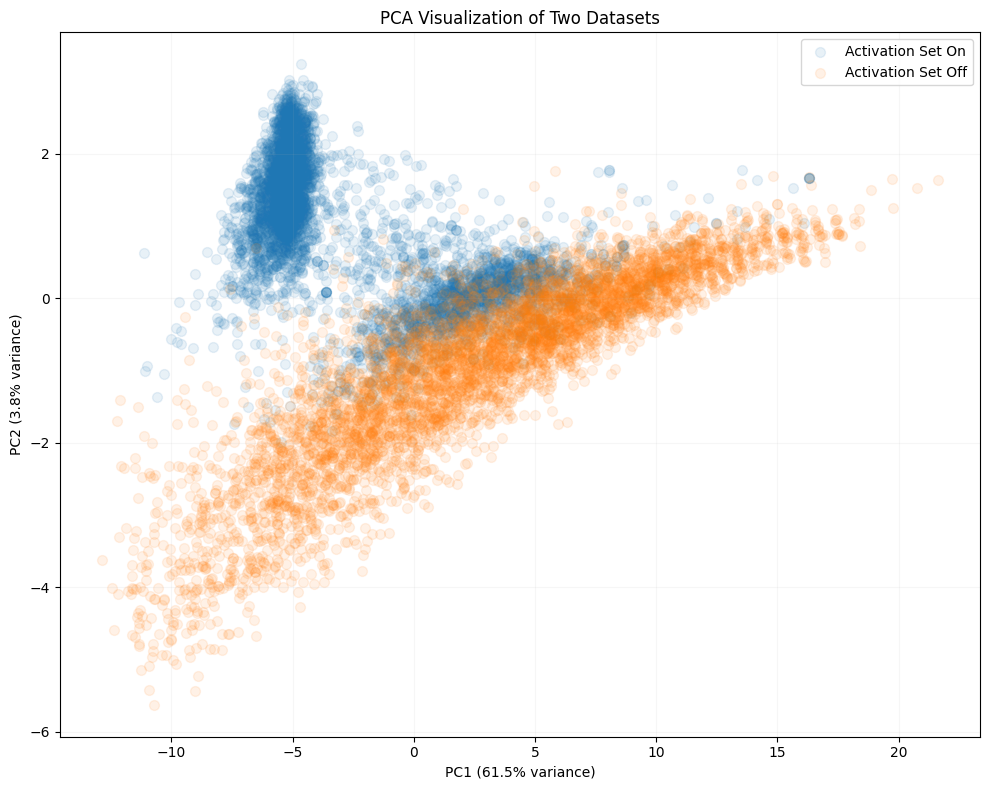

Dataset 1 shape: (5000, 3072)
Dataset 2 shape: (5000, 3072)
Combined dataset shape: (10000, 3072)
PCA explained variance ratio: [0.61495775 0.0381452 ]
Total explained variance: 65.3%


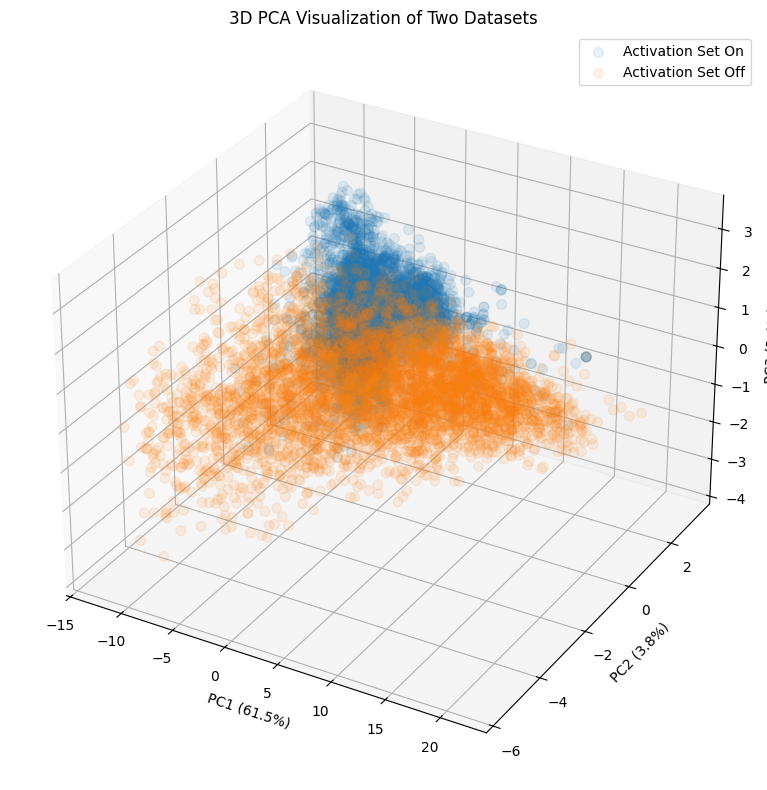

Dataset 1 shape: (5000, 3072)
Dataset 2 shape: (5000, 3072)
Combined dataset shape: (10000, 3072)
PCA explained variance ratio: [0.61495775 0.03814515 0.02376399]
Total explained variance: 67.7%


In [3]:
from probe_gen.analysis import plot_activations_pca

# 2D visualization
pca_2d, transformed_2d, labels = plot_activations_pca(
    activations_tensor_on, 
    activations_tensor_off, 
    n_components=2,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off",
    alpha=0.1
)

# 3D visualization
pca_3d, transformed_3d, labels = plot_activations_pca(
    activations_tensor_on, 
    activations_tensor_off, 
    n_components=3,
    dataset1_name="Activation Set On", 
    dataset2_name="Activation Set Off",
    alpha=0.1
)